/root/anaconda3/envs/cpu/lib/python3.6/site-packages/gym/core.py:26: UserWarning: WARN: Gym minimally supports python 3.6 as the python foundation not longer supports the version, please update your version to 3.7+
  "Gym minimally supports python 3.6 as the python foundation not longer supports the version, please update your version to 3.7+"
/root/anaconda3/envs/cpu/lib/python3.6/site-packages/gym/core.py:330: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  "Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future."
/root/anaconda3/envs/cpu/lib/python3.6/site-packages/gym/wrappers/step_api_compatibility.py:40: DeprecationWarning: WARN: Initializing environment in old step API which returns o

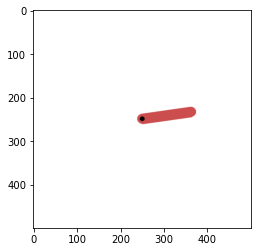

In [1]:
import gym
from matplotlib import pyplot as plt
%matplotlib inline

#创建环境
env = gym.make('Pendulum-v1')
env.reset()


#打印游戏
def show():
    plt.imshow(env.render(mode='rgb_array'))
    plt.show()


show()

In [2]:
import torch


class Model(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.sequential = torch.nn.Sequential(
            torch.nn.Linear(3, 64),
            torch.nn.ReLU(),
            torch.nn.Linear(64, 64),
            torch.nn.ReLU(),
            torch.nn.Linear(64, 1),
            torch.nn.Tanh(),
        )

    def forward(self, state):
        return self.sequential(state) * 2.0


model_action = Model()
model_action_next = Model()

model_action_next.load_state_dict(model_action.state_dict())

model_action(torch.randn(1, 3))

tensor([[-0.2562]], grad_fn=<MulBackward0>)

In [3]:
model_value = torch.nn.Sequential(
    torch.nn.Linear(4, 64),
    torch.nn.ReLU(),
    torch.nn.Linear(64, 64),
    torch.nn.ReLU(),
    torch.nn.Linear(64, 1),
)
model_value_next = torch.nn.Sequential(
    torch.nn.Linear(4, 64),
    torch.nn.ReLU(),
    torch.nn.Linear(64, 64),
    torch.nn.ReLU(),
    torch.nn.Linear(64, 1),
)

model_value_next.load_state_dict(model_value.state_dict())

model_value(torch.randn(1, 4))

tensor([[0.0311]], grad_fn=<AddmmBackward0>)

In [4]:
import random
import numpy as np


def get_action(state):
    state = torch.FloatTensor(state).reshape(1, 3)
    action = model_action(state).item()
    #给动作添加噪声,增加探索
    action += random.normalvariate(mu=0, sigma=0.01)
    return action


get_action([1, 2, 3])

-0.0794577558499697

In [5]:
#样本池
datas = []


#向样本池中添加N条数据,删除M条最古老的数据
def update_data():
    #初始化游戏
    state = env.reset()

    #玩到游戏结束为止
    over = False
    while not over:
        #根据当前状态得到一个动作
        action = get_action(state)

        #执行动作,得到反馈
        next_state, reward, over, _ = env.step([action])

        #记录数据样本
        datas.append((state, action, reward, next_state, over))

        #更新游戏状态,开始下一个动作
        state = next_state

    #数据上限,超出时从最古老的开始删除
    while len(datas) > 10000:
        datas.pop(0)


update_data()

len(datas), datas[0]

(200,
 (array([ 0.9781273 , -0.20800708, -0.94385123], dtype=float32),
  -0.04984974862998363,
  -0.1329937692558043,
  array([ 0.9651177 , -0.26181635, -1.107334  ], dtype=float32),
  False))

In [6]:
#获取一批数据样本
def get_sample():
    #从样本池中采样
    samples = random.sample(datas, 64)

    #[b, 3]
    state = torch.FloatTensor([i[0] for i in samples]).reshape(-1, 3)
    #[b, 1]
    action = torch.FloatTensor([i[1] for i in samples]).reshape(-1, 1)
    #[b, 1]
    reward = torch.FloatTensor([i[2] for i in samples]).reshape(-1, 1)
    #[b, 3]
    next_state = torch.FloatTensor([i[3] for i in samples]).reshape(-1, 3)
    #[b, 1]
    over = torch.LongTensor([i[4] for i in samples]).reshape(-1, 1)

    return state, action, reward, next_state, over


state, action, reward, next_state, over = get_sample()

state[:5], action[:5], reward[:5], next_state[:5], over[:5]

/root/anaconda3/envs/cpu/lib/python3.6/site-packages/ipykernel_launcher.py:7: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  /opt/conda/conda-bld/pytorch_1640811701593/work/torch/csrc/utils/tensor_new.cpp:201.)
  import sys


(tensor([[ 0.9422, -0.3351, -3.3499],
         [ 0.7944,  0.6073, -4.1651],
         [ 0.5650, -0.8251, -4.6804],
         [ 0.9996, -0.0274, -3.1510],
         [ 0.9400, -0.3411, -3.3633]]),
 tensor([[-0.2925],
         [-0.1565],
         [-0.6216],
         [-0.1859],
         [-0.2984]]),
 tensor([[-1.2391],
         [-2.1608],
         [-3.1326],
         [-0.9937],
         [-1.2524]]),
 tensor([[ 0.8658, -0.5003, -3.6451],
         [ 0.8933,  0.4494, -3.7331],
         [ 0.3248, -0.9458, -5.3925],
         [ 0.9825, -0.1863, -3.1995],
         [ 0.8622, -0.5066, -3.6639]]),
 tensor([[0],
         [0],
         [0],
         [0],
         [0]]))

In [7]:
from IPython import display


def test(play):
    #初始化游戏
    state = env.reset()

    #记录反馈值的和,这个值越大越好
    reward_sum = 0

    #玩到游戏结束为止
    over = False
    while not over:
        #根据当前状态得到一个动作
        action = get_action(state)

        #执行动作,得到反馈
        state, reward, over, _ = env.step([action])
        reward_sum += reward

        #打印动画
        if play and random.random() < 0.2:  #跳帧
            display.clear_output(wait=True)
            show()

    return reward_sum


test(play=False)

-1070.7204075649688

In [8]:
def get_value(state, action):
    #直接评估综合了state和action的value
    #[b, 3+1] -> [b, 4]
    input = torch.cat([state, action], dim=1)

    #[b, 4] -> [b, 1]
    return model_value(input)


def get_target(next_state, reward, over):
    #对next_state的评估需要先把它对应的动作计算出来,这里用model_action_next来计算
    #[b, 3] -> [b, 1]
    action = model_action_next(next_state)

    #和value的计算一样,action拼合进next_state里综合计算
    #[b, 3+1] -> [b, 4]
    input = torch.cat([next_state, action], dim=1)

    #[b, 4] -> [b, 1]
    target = model_value_next(input) * 0.98

    #[b, 1] * [b, 1] -> [b, 1]
    target *= (1 - over)

    #[b, 1] + [b, 1] -> [b, 1]
    target += reward

    return target


get_value(state, action)[:5], get_target(next_state, reward, over)[:5]

(tensor([[-0.0367],
         [-0.0285],
         [-0.1399],
         [-0.0137],
         [-0.0375]], grad_fn=<SliceBackward0>),
 tensor([[-1.2954],
         [-2.1755],
         [-3.3287],
         [-1.0163],
         [-1.3098]], grad_fn=<SliceBackward0>))

In [9]:
def get_loss_action(state):
    #首先把动作计算出来
    #[b, 3] -> [b, 1]
    action = model_action(state)

    #像value计算那里一样,拼合state和action综合计算
    #[b, 3+1] -> [b, 4]
    input = torch.cat([state, action], dim=1)

    #使用value网络评估动作的价值,价值是越高越好
    #因为这里是在计算loss,loss是越小越好,所以符号取反
    #[b, 4] -> [b, 1] -> [1]
    loss = -model_value(input).mean()

    return loss


get_loss_action(state)

tensor(0.1446, grad_fn=<NegBackward0>)

In [10]:
def soft_update(model, model_next):
    for param, param_next in zip(model.parameters(), model_next.parameters()):
        #以一个小的比例更新
        value = param_next.data * 0.995 + param.data * 0.005
        param_next.data.copy_(value)


soft_update(torch.nn.Linear(4, 64), torch.nn.Linear(4, 64))

In [11]:
def train():
    model_action.train()
    model_value.train()
    optimizer_action = torch.optim.Adam(model_action.parameters(), lr=5e-4)
    optimizer_value = torch.optim.Adam(model_value.parameters(), lr=5e-3)
    loss_fn = torch.nn.MSELoss()

    #训练N次
    for epoch in range(200):
        #更新N条数据
        update_data()

        #每次更新过数据后,学习N次
        for i in range(200):
            #采样一批数据
            state, action, reward, next_state, over = get_sample()

            #计算value和target
            value = get_value(state, action)
            target = get_target(next_state, reward, over)

            #两者求差,计算loss,更新参数
            loss_value = loss_fn(value, target)

            optimizer_value.zero_grad()
            loss_value.backward()
            optimizer_value.step()

            #使用value网络评估action网络的loss,更新参数
            loss_action = get_loss_action(state)

            optimizer_action.zero_grad()
            loss_action.backward()
            optimizer_action.step()

            #以一个小的比例更新
            soft_update(model_action, model_action_next)
            soft_update(model_value, model_value_next)

        if epoch % 20 == 0:
            test_result = sum([test(play=False) for _ in range(10)]) / 10
            print(epoch, len(datas), test_result)


train()

0 400 -1426.9143485602572
20 4400 -782.2665580151744
40 8400 -181.24392126393508
60 10000 -213.92405181783744
80 10000 -158.83671365329474
100 10000 -152.75725311945126
120 10000 -162.96483997992166
140 10000 -172.0843508589916
160 10000 -134.7957615513623
180 10000 -79.0563939012981


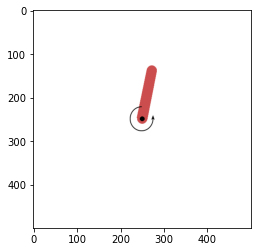

-246.88427889497422

In [12]:
test(play=True)